In [1]:
sys.path.append('../')
from PINN_Survey.architecture.tf_v1.soft_mesh import Soft_Mesh
from PINN_Survey.problems.burgers.v1 import residual
from PINN_Survey.problems.burgers.data.load import load_burgers_bounds
from PINN_Base.util import random_choice, bounds_from_data
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
class HardMesh(Soft_Mesh):

    def _forward_mesh(self,X,weights,biases):

        return self._NN(X,weights,biases)

class HardMesh_Burgers(HardMesh):

    def __init__(self,
                 lower_bound,
                 upper_bound,
                 layers_approx,
                 layers_mesh,
                 nu,
                 **kwargs
                 ):

        self.nu = nu
        super().__init__(lower_bound, upper_bound, layers_approx, layers_mesh, **kwargs)

    def _residual(self, u, x, _=None):
        return residual(self, u, x)

In [2]:
X_true, U_true, X_bounds, U_bounds, _ = load_burgers_bounds()

lower_bound,upper_bound = bounds_from_data(X_true)

X = np.vstack(X_bounds)
U = np.vstack(U_bounds)

X_df = random_choice(X_true)

In [6]:
model = HardMesh_Burgers(lower_bound,upper_bound, [2,20,20,1],[2,20,20,20,20,20,20], 0.01/np.pi)

In [12]:
model = HardMesh_Burgers(lower_bound,upper_bound, [2,20,20,1],[2,20,20,20,20,20,20], 0.01/np.pi)
model.train_BFGS(X,U,X_df,True)

U_hat = model.predict(X_true)

print("RMSE:", np.sqrt(np.mean( (U_true[:,0] - U_hat[:,0])**2 )) )
print("Relative Error", np.linalg.norm(U_true-U_hat,2)/np.linalg.norm(U_true,2))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000024
  Number of iterations: 6515
  Number of functions evaluations: 7239
RMSE: 0.006562675142038493
Relative Error 0.010682523845537998


In [18]:
class SquishMesh(Soft_Mesh):

    def _forward_mesh(self,X,weights,biases):

        scores,activations = self._NN(X,weights,biases)

        return tf.tanh(scores), activations

class SquishMesh_Burgers(SquishMesh):

    def __init__(self,
                 lower_bound,
                 upper_bound,
                 layers_approx,
                 layers_mesh,
                 nu,
                 **kwargs
                 ):

        self.nu = nu
        super().__init__(lower_bound, upper_bound, layers_approx, layers_mesh, **kwargs)

    def _residual(self, u, x, _=None):
        return residual(self, u, x)

In [21]:
model = SquishMesh_Burgers(lower_bound,upper_bound, [2,20,20,1],[2,20,20,20,20,20,20], 0.01/np.pi)
model.train_BFGS(X,U,X_df,True)

U_hat = model.predict(X_true)

print("RMSE:", np.sqrt(np.mean( (U_true[:,0] - U_hat[:,0])**2 )) )
print("Relative Error", np.linalg.norm(U_true-U_hat,2)/np.linalg.norm(U_true,2))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000013
  Number of iterations: 6002
  Number of functions evaluations: 6476
RMSE: 0.005441730290335267
Relative Error 0.008857883763759811


In [11]:
class SphereMesh(Soft_Mesh):

    def _forward_mesh(self,X,weights,biases):

        scores,activations = self._NN(X,weights,biases)

        z = tf.square(scores)
        norm = tf.reduce_sum(z,axis=1)[:,None]

        return z/norm, activations

class SphereMesh_Burgers(SphereMesh):

    def __init__(self,
                 lower_bound,
                 upper_bound,
                 layers_approx,
                 layers_mesh,
                 nu,
                 **kwargs
                 ):

        self.nu = nu
        super().__init__(lower_bound, upper_bound, layers_approx, layers_mesh, **kwargs)

    def _residual(self, u, x, _=None):
        return residual(self, u, x)

In [12]:
model = SphereMesh_Burgers(lower_bound,upper_bound, [2,20,20,1],[2,20,20,20,20,20,20], 0.01/np.pi)
model.train_BFGS(X,U,X_df,True)

U_hat = model.predict(X_true)

print("RMSE:", np.sqrt(np.mean( (U_true[:,0] - U_hat[:,0])**2 )) )
print("Relative Error", np.linalg.norm(U_true-U_hat,2)/np.linalg.norm(U_true,2))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000001
  Number of iterations: 5773
  Number of functions evaluations: 6204
RMSE: 0.00046783699400028265
Relative Error 0.000761530890386334


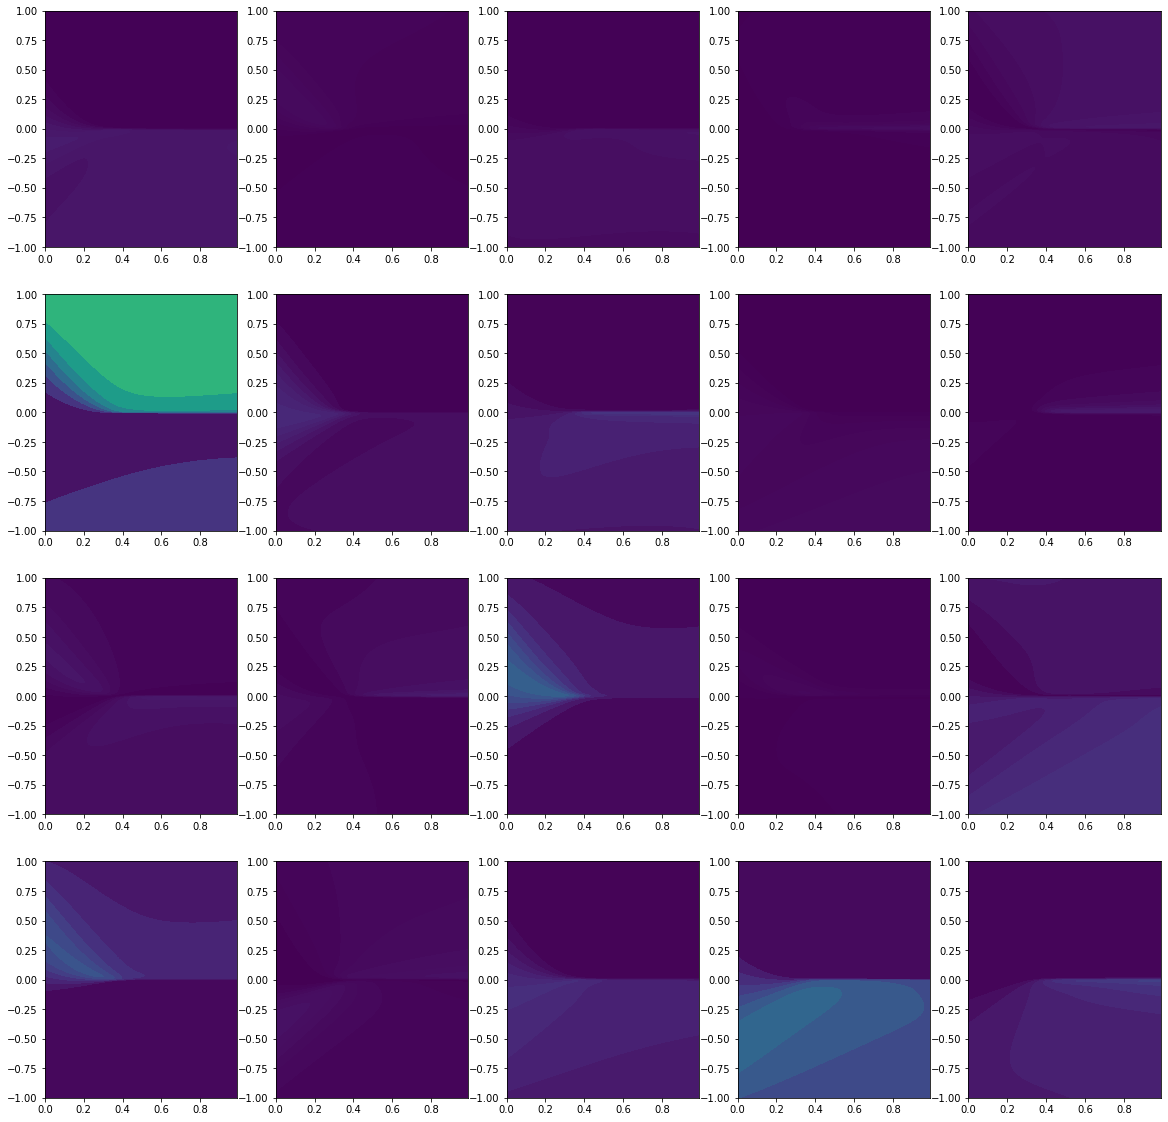

In [13]:
mesh_functions = model.get_probs(X_true)

fig, axes = plt.subplots(4,5, figsize=(20,20))

for row in range(4):
    for col in range(5):
        axes[row,col].tricontourf(X_true[:,1], X_true[:,0], mesh_functions[:,row*5 + col],vmin=0,vmax=1)

In [25]:
class AbsMesh(Soft_Mesh):

    def _forward_mesh(self,X,weights,biases):

        scores,activations = self._NN(X,weights,biases)

        z = tf.abs(scores)
        norm = tf.reduce_sum(z,axis=1)[:,None]

        return z/norm, activations

class AbsMesh_Burgers(AbsMesh):

    def __init__(self,
                 lower_bound,
                 upper_bound,
                 layers_approx,
                 layers_mesh,
                 nu,
                 **kwargs
                 ):

        self.nu = nu
        super().__init__(lower_bound, upper_bound, layers_approx, layers_mesh, **kwargs)

    def _residual(self, u, x, _=None):
        return residual(self, u, x)

In [28]:
model = AbsMesh_Burgers(lower_bound,upper_bound, [2,20,20,1],[2,20,20,20,20,20,20], 0.01/np.pi)
model.train_BFGS(X,U,X_df,True)

U_hat = model.predict(X_true)

print("RMSE:", np.sqrt(np.mean( (U_true[:,0] - U_hat[:,0])**2 )) )
print("Relative Error", np.linalg.norm(U_true-U_hat,2)/np.linalg.norm(U_true,2))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.123487
  Number of iterations: 29
  Number of functions evaluations: 101
RMSE: 0.36822008938164175
Relative Error 0.5993775099469106


In [8]:
class FEMMesh(Soft_Mesh):

    def _forward_mesh(self,X,weights,biases):

        scores,activations = self._NN(X,weights,biases)

        z = tf.square(scores)
        norm = tf.reduce_sum(z,axis=1)[:,None]

        return z/norm, activations

    def _forward_approx(self,X,weights,biases):
        activations = []

        H = 2.0 * (X - self.lower_bound) / \
            (self.upper_bound - self.lower_bound) - 1.0
        activations.append(H)

        for l in range(len(weights)-1):
            W = weights[l]
            b = biases[l]
            H = tf.nn.relu(tf.add(tf.matmul(H, W), b))
            activations.append(H)

        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)

        return Y, activations        

class FEMMesh_Burgers(FEMMesh):

    def __init__(self,
                 lower_bound,
                 upper_bound,
                 layers_approx,
                 layers_mesh,
                 nu,
                 **kwargs
                 ):

        self.nu = nu
        super().__init__(lower_bound, upper_bound, layers_approx, layers_mesh, **kwargs)

    def _residual(self, u, x, _=None):
        return residual(self, u, x)

In [9]:
model = FEMMesh_Burgers(lower_bound,upper_bound, [2,20,20,1],[2,20,20,20,20,20,20], 0.01/np.pi)
model.train_BFGS(X,U,X_df,True)

U_hat = model.predict(X_true)

print("RMSE:", np.sqrt(np.mean( (U_true[:,0] - U_hat[:,0])**2 )) )
print("Relative Error", np.linalg.norm(U_true-U_hat,2)/np.linalg.norm(U_true,2))




INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.013495
  Number of iterations: 204
  Number of functions evaluations: 362
RMSE: 0.1565315362249321
Relative Error 0.2547972941080441
